# Well-tie Sleipner dataset

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from pylops.avo.poststack import PoststackLinearModelling
from pysubsurface.objects import Project, seismic
from pysubsurface.objects.utils import _findclosest_point
from scipy.interpolate.interpolate import interp1d
from scipy.signal import filtfilt, resample

## Load Seismic and Well data

This notebook leverages the Pysubsurface library to load and manipulate seismic and well data.

In [2]:
project = Project(projectdir='../data/Sleipner_pysubsurface/', projectname='Sleipner', kind='local', warnings=False)
project.picks.df['Field'] = 'Sleipner'
project.picks.df['Name'] = project.picks.df['Name'].str.replace('_', ' ')
project.picks.df['Well UWI'] = project.picks.df['Well UWI'].str.replace('_', ' ')
selwellsnames = ['15_9-13', '15_9-A-16']
selwellsrenames = ['NO 15/9-13', 'NO 15/9-A16']
project.wells = {}
project.add_wells(wellnames=selwellsnames, renames=selwellsrenames, computetvdss=False, verb=True)

Loading well 15_9-13 with name NO 15/9-13 (purpose = None)
Loading well 15_9-A-16 with name NO 15/9-A16 (purpose = None)


In [3]:
# Loading seismic
seismicfile_d = '01p07ful'
project.add_seismic(seismicfile_d, name=seismicfile_d,
                    type='Post', domain='time', loadcube=True)

seismicfile_db = '94p07ful'
project.add_seismic(seismicfile_db, name=seismicfile_db,
                    type='Post', domain='time', loadcube=True)

## Find the closest trace to the well top and bottom

In [6]:
# Closest inline and xline of the well-bottom
well = 'NO 15/9-13'
xhead, yhead = project.wells[well].trajectory.df.iloc[-1]['X Absolute'], project.wells[well].trajectory.df.iloc[-1][
    'Y Absolute']
ilwell, xlwell = _findclosest_point((xhead, yhead), project.seismics[seismicfile_d]['data'])
print('well bottom IL/XL :', ilwell, ',', xlwell)

# Closest inline and xline at the top of the well
xhead, yhead = project.wells[well].trajectory.df.iloc[0]['X Absolute'], project.wells[well].trajectory.df.iloc[0][
    'Y Absolute']
ilwell, xlwell = _findclosest_point((xhead, yhead), project.seismics[seismicfile_d]['data'])
print('well top IL/XL :', ilwell, ',', xlwell)

# As the well is nearly vertical we are going to take into account only the top coordinates or IL/XL positions.
IL_ref = np.argwhere(project.seismics[seismicfile_db]['data'].ilines == ilwell)[0][0]
XL_ref = np.argwhere(project.seismics[seismicfile_db]['data'].xlines == xlwell)[0][0]
print(IL_ref, XL_ref)

# We select the iline that goes through the well top and remove part of the underborden to make it smaller.
il_base = project.seismics[seismicfile_db]['data'].data[IL_ref, :, :680].T
il_monitor = project.seismics[seismicfile_d]['data'].data[IL_ref, :, :680].T

well bottom IL/XL : 1769 , 1100
well top IL/XL : 1773 , 1099
57 143


## Well-log edition

In [7]:
# well-log editing
depth = project.wells['NO 15/9-13'].welllogs.logs['DEPTH']
DT = project.wells['NO 15/9-13'].welllogs.logs['DT']
DT_CKS = project.wells['NO 15/9-13'].welllogs.logs['DT-CKS']

# DT-CKS log edition
DT_ = DT_CKS.copy()

# 1. Replace DT-CKS log data @ reservoir interval by DT log data (and apply small shift)
DT_[5650:6950] = project.wells['NO 15/9-13'].welllogs.logs['DT'][5650:6950] - 10

# 2. Replace the anomalous values by 100 (for anomalous values under 100) or 200 (for anomalous values over 200)
DT_[1000 + np.argwhere(DT_[1000:] > 200)] = 200
DT_[np.argwhere(DT_ < 100)] = 100

# 3. Fill the nans with the last value read.
DT_[0] = 206.2271  # we assign a slowness to the first layer
for i in range(1, DT_.shape[0]):
    if np.isnan(DT_[i]):
        DT_[i] = DT_[i - 1]

# 4. Convert to m/s
vp = (0.3048 * 1e6) / DT_

# 5. Den log: Replace nans by an average value of 1.85

den = project.wells['NO 15/9-13'].welllogs.logs['RHOB']
den[0] = 1.85
for i in range(1, den.shape[0]):
    if np.isnan(den[i]):
        den[i] = den[i - 1]
den[:595] = 1.  # water table density

# 6. Impedance log
m = vp * den

# This is equivalent smoothing to the one used for the background model later on
nsmooth = 200
m_sm = filtfilt(np.ones(nsmooth) / float(nsmooth), 1, m)
m_sm[:595] = m_sm[0]

Text(0.5, 1.0, 'Impedance')

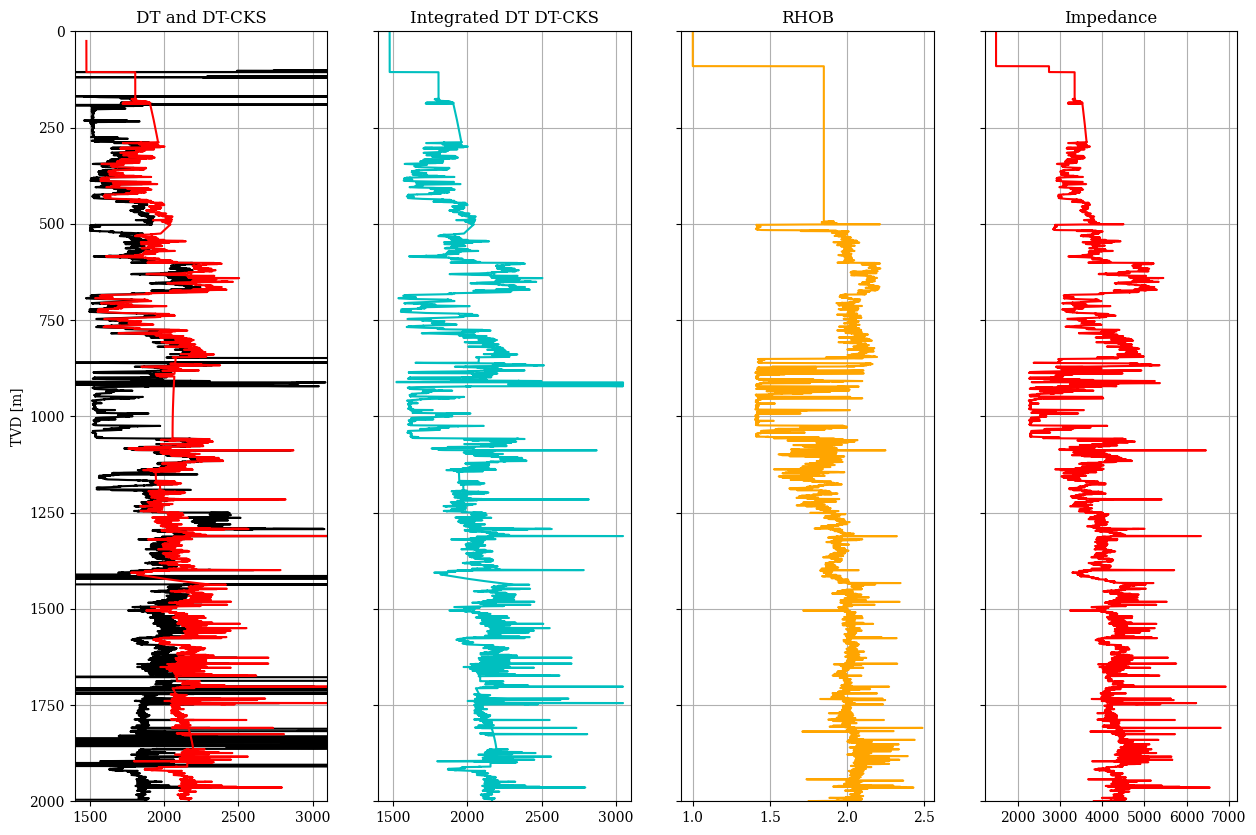

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(15, 10), sharey=True)
axes[0].plot((0.3048 * 1e6) / DT, depth, 'k')
axes[0].plot((0.3048 * 1e6) / DT_CKS, depth, 'r')
axes[0].set_ylim(2000, 0)
axes[0].set_xlim(1400, 3100)
axes[0].set_title('DT and DT-CKS')
axes[0].grid()
# axes[0].set_title('$V_p$ [m/s]')
axes[0].set_ylabel('TVD [m]')
axes[1].plot(vp, depth, 'c')
axes[1].set_ylim(2000, 0)
axes[1].set_xlim(1400, 3100)
axes[1].grid()
axes[1].set_title('Integrated DT DT-CKS')
axes[2].plot(den, depth, 'orange')
axes[2].set_ylim(2000, 0)
axes[2].grid()
axes[2].set_title('RHOB')
axes[3].plot(m, depth, 'r')
axes[3].set_ylim(2000, 0)
axes[3].grid()
axes[3].set_title('Impedance')

## Time-Depth relationship

In [11]:
# Time-depth curve
TWT_samples = np.array([0, 54., 450., 545.])
Log_samples_depth = np.array([0, 106.22, 848.87, 1054.61])
Log_samples = np.array([0, 697., 5570., 6920.])
f = interp1d(Log_samples, TWT_samples, fill_value='extrapolate')
TWT_log_idx = f(np.arange(0, m.shape[0]))
g = interp1d(TWT_log_idx * 0.002, m, fill_value='extrapolate')
Imp_TWT = g(np.linspace(0, 2, m.shape[0]))
Imp_TWT_rs = resample(Imp_TWT, 1001)
nsmooth = 20
Imp_TWT_rs_sm = filtfilt(np.ones(nsmooth) / float(nsmooth), 1, Imp_TWT_rs)
Imp_TWT_rs[:54] = 1500  # water later impedance
Imp_TWT_rs_sm[:54] = 1500  # water later impedance
Imp_TWT_rs[-50:] = 4300  # anomalous values at the bottom
Imp_TWT_rs_sm[-50:] = 4300  # anomalous values at the bottom

# Repeat imp profile to make 2D section
imp_model1 = np.repeat(Imp_TWT_rs_sm[:, np.newaxis], il_base.shape[1], axis=1)

## Wavelet Extraction and Synthetic Seismic

In [12]:
wav_base, wavf = project.seismics[seismicfile_db]['data'].estimate_wavelet(
    method='stat', ntwest=(61 + 1) // 2, tzlims=[800, 1200],
    jil=10, jxl=10, plotflag=False,
    **dict(nfft=2 ** 10, nsmooth=4))
wav_moni, wavf_ = project.seismics[seismicfile_d]['data'].estimate_wavelet(
    method='stat', ntwest=(61 + 1) // 2, tzlims=[800, 1200],
    jil=10, jxl=10, plotflag=False,
    **dict(nfft=2 ** 10, nsmooth=4))

# 400:600 around the reservoir
Lop_base = PoststackLinearModelling(wav_base, nt0=Imp_TWT_rs.size)
d_log_base = Lop_base * np.log(Imp_TWT_rs)
wavscaling_b = np.sqrt(np.sum(il_base[400:600, 150] ** 2) / np.sum(d_log_base[400:600] ** 2))
wav_base = wavscaling_b * wav_base

Lop_moni = PoststackLinearModelling(wav_moni, nt0=Imp_TWT_rs.size)
d_log_moni = Lop_moni * np.log(Imp_TWT_rs)
wavscaling_m = np.sqrt(np.sum(il_monitor[400:600, 150] ** 2) / np.sum(d_log_moni[400:600] ** 2))
wav_moni = wavscaling_m * wav_moni

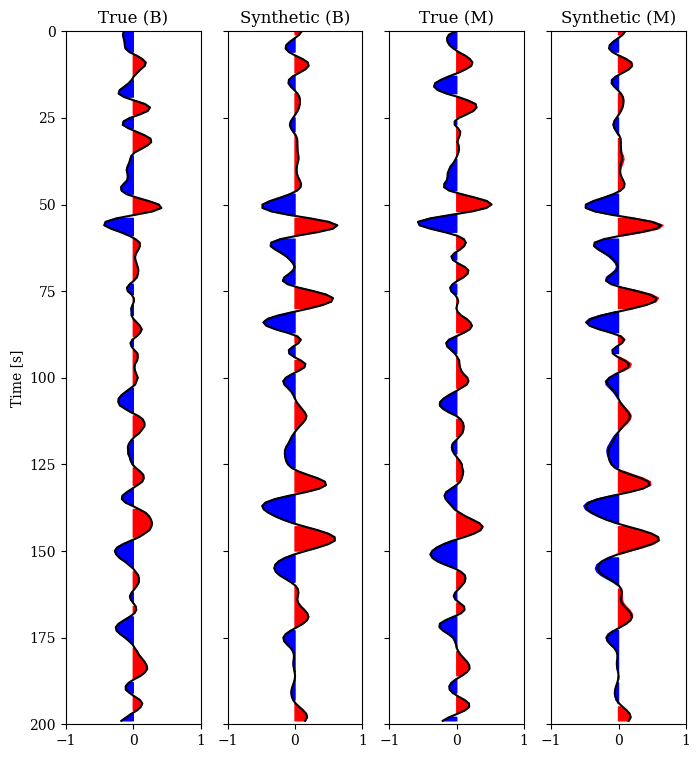

In [13]:
vmin, vmax = np.percentile(il_base, [3, 97])
fig, axs = plt.subplots(1, 4, figsize=(8, 9), sharey=True)
axs[0].plot(il_base[400:600, 150], np.arange(0, 200), 'k')
axs[0].fill_betweenx(np.arange(0, 200), 0, il_base[400:600, 150], where=np.array(il_base[400:600, 150]) > 0, color='r')
axs[0].fill_betweenx(np.arange(0, 200), 0, il_base[400:600, 150], where=np.array(il_base[400:600, 150]) < 0, color='b')
axs[0].set_title('True (B)')
axs[0].set_ylim(200, 0)
axs[0].set_xlim(-1, 1)
axs[0].set_ylabel('Time [s]')
axs[1].plot(d_log_base[400:600] / 1, np.arange(0, 200), 'k')
axs[1].fill_betweenx(np.arange(0, 200), 0, d_log_base[400:600], where=np.array(d_log_base[400:600]) > 0, color='r')
axs[1].fill_betweenx(np.arange(0, 200), 0, d_log_base[400:600], where=np.array(d_log_base[400:600]) < 0, color='b')
axs[1].set_title('Synthetic (B)')
axs[1].set_ylim(200, 0);
axs[1].set_xlim(-1, 1);
axs[2].plot(il_monitor[400:600, 150], np.arange(0, 200), 'k')
axs[2].fill_betweenx(np.arange(0, 200), 0, il_monitor[400:600, 150], where=np.array(il_monitor[400:600, 150]) > 0,
                     color='r')
axs[2].fill_betweenx(np.arange(0, 200), 0, il_monitor[400:600, 150], where=np.array(il_monitor[400:600, 150]) < 0,
                     color='b')
axs[2].set_title('True (M)')
axs[2].set_ylim(200, 0)
axs[2].set_xlim(-1, 1)
axs[3].plot(d_log_base[400:600] / 1, np.arange(0, 200), 'k')
axs[3].fill_betweenx(np.arange(0, 200), 0, d_log_moni[400:600], where=np.array(d_log_moni[400:600]) > 0, color='r')
axs[3].fill_betweenx(np.arange(0, 200), 0, d_log_moni[400:600], where=np.array(d_log_moni[400:600]) < 0, color='b')
axs[3].set_title('Synthetic (M)')
axs[3].set_ylim(200, 0);
axs[3].set_xlim(-1, 1);

Text(0.5, 1.0, 'Monitor well-tie')

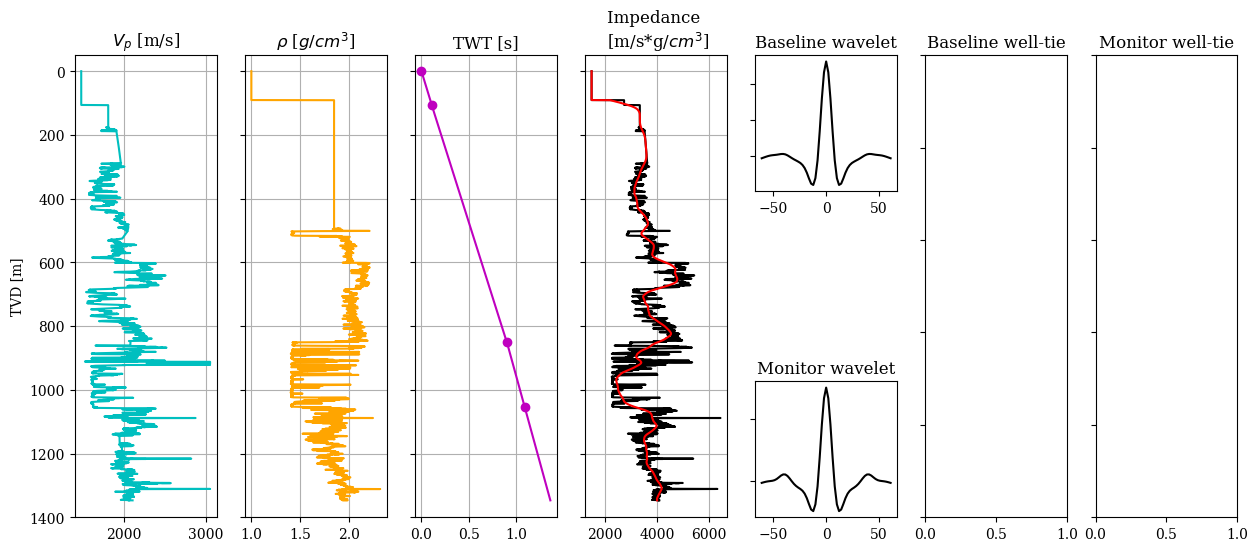

In [14]:
# plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplot_mosaic("ABCDEHI;ABCDFHI;ABCDGHI", figsize=(15, 6))
axes['A'].plot(vp[:8839], depth[:8839], 'c')
axes['A'].set_ylim(1400, -50)
axes['A'].grid()
axes['A'].set_title('$V_p$ [m/s]')
axes['A'].set_ylabel('TVD [m]')
axes['B'].plot(den[:8839], depth[:8839], 'orange')
axes['B'].set_ylim(1400, -50)
axes['B'].grid()
axes['B'].set_yticklabels([])
axes['B'].set_title(r'$\rho$ [$g/cm^3$]')
axes['C'].plot(TWT_log_idx[:8839] * 0.002, depth[:8839], 'm')
axes['C'].plot(TWT_samples * 0.002, Log_samples_depth, 'om')
axes['C'].set_ylim(1400, -50)
axes['C'].grid()
axes['C'].set_title('TWT [s]')
axes['C'].set_yticklabels([])
axes['D'].plot(m[:8839], depth[:8839], 'k')
axes['D'].plot(m_sm[:8839], depth[:8839], 'r')
axes['D'].grid()
axes['D'].set_yticklabels([])
axes['D'].set_ylim(1400, -50)
# axes['D'].legend(['Impedance log', 'Smoothed'],)
axes['D'].set_title('Impedance \n [m/s*g/$cm^3$]')
axes['E'].plot(np.linspace(-61, 61, 61), wav_base, 'k')
axes['E'].set_yticklabels([])
axes['E'].set_title('Baseline wavelet')
axes['F'].axis('off')
axes['G'].plot(np.linspace(-61, 61, 61), wav_moni, 'k')
axes['G'].set_yticklabels([])
axes['G'].set_title('Monitor wavelet')
axes['H'].set_yticklabels([])
axes['H'].set_title('Baseline well-tie')
axes['I'].set_yticklabels([])
axes['I'].set_title('Monitor well-tie')
# axes['I'].yaxis.tick_right()
# fig.tight_layout()